# Outcomes in Blood and Marrow Transplantation (EBMT)

- available at: <https://www.math.uwaterloo.ca/~rjcook/cook-lawless-multistate_data.html>
- used in `cook2018multistate`

In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

import collections
import csv
import matplotlib.pyplot as plt
import numpy as np

from mixmarkov import (
    CTMC,
    FiniteMixCTMC,
    GamMixCTMC,
    summarize_sequences,
)
from mixmarkov.baselines import CTRNN, seqs_to_tensor
from mixmarkov.utils import draw_chain

## Loading the data

- `id`: identifier of patient
- `from`: source state
- `to`: destination state
- `trans`: transition ID
- `Tstart`: start time (days)
- `Tstop`: stop time (days)
- `time`: interval between start and stop
- `status`: 1 if transition happens, 0 otherwise
- `match`: either `no gender mismatch` or `gender mismatch`
- `proph`: prohylaxis, either `yes` or `no`
- `year`: year of transplantation: `1985-1989`, `1990-1994`, `1995-1998`
- `agecl`: age class at transplant: `<=20`, `20-40`, `>40`

states:

- 1: alive, no recovery or adverse event
- 2: alive in remission, recovered from treatment
- 3: adverse event occurred
- 4: adverse event + recovery
- 5: alive in relapse (due to treatment failure)
- 6: dead (due to treatment failure)

In [2]:
rng = np.random.default_rng(seed=0)

vecs_year = rng.normal(size=(3, 10))
year_map = {
    "1985-1989": vecs_year[0],
    "1990-1994": vecs_year[1],
    "1995-1998": vecs_year[2],
}

vecs_agecl = rng.normal(size=(3, 10))
agecl_map = {
    "<=20": vecs_agecl[0],
    "20-40": vecs_agecl[1],
    ">40": vecs_agecl[2],
}

In [3]:
rng = np.random.default_rng(seed=0)

seqs = list()
feats = list()

with open("../data/ebmt.dat") as f:
    #next(f)  # First line is header.
    cur = None
    for row in csv.DictReader(f, delimiter=" "):
        #idx, src, dst, _, start, stop, _, status, match, proph, year, agecls = line.strip().split(" ")
        src = int(row["from"]) - 1
        dst = int(row["to"]) - 1
        if row["id"] != cur:
            if cur is not None:
                if seq[-1][1] < max_stop:
                    seq.append((seq[-1][0], max_stop))
                seqs.append(seq)
            seq = list()
            cur = row["id"]
            seq.append((src, float(row["Tstart"])))
            feats.append(np.concatenate((
                year_map[row["year"]],
                agecl_map[row["agecl"]],
                rng.normal(size=(20,))
            )))
        if row["status"] == "1":
            seq.append((dst, float(row["Tstop"])))
        max_stop = float(row["Tstop"])
    seqs.append(seq)
    
# Shuffle the sequences.
idx = rng.permutation(len(seqs))
seqs = np.array(seqs, dtype=object)[idx]
feats = np.array(feats)[idx]

# states: 6
# sequences: 2,279
# edges: 12


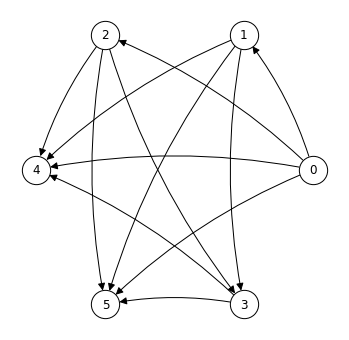

In [4]:
states = set()
for seq in seqs:
    for x, y in seq:
        states.add(x)

n = len(states)
        
ks, _ = summarize_sequences(seqs, n)
mask = np.sum(ks, axis=0).astype(bool)
np.fill_diagonal(mask, False)  # Remove self-transitions

print(f"# states: {n:,}")
print(f"# sequences: {len(seqs):,}")
print(f"# edges: {mask.sum():,}")

draw_chain(mask)

## Final evaluation

Setting $\ell_2 = 3.0$ worked best out of the following values: $(0.1, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0)$

In [5]:
%%time
model1 = CTMC(mask)
model2 = GamMixCTMC(mask)

n_splits = 10
zs = np.linspace(0, len(seqs), num=(n_splits + 1), dtype=int)

res1 = np.zeros(n_splits)
res2 = np.zeros(n_splits)

for i, (z1, z2) in enumerate(zip(zs[:-1], zs[1:])):
    train = np.concatenate((seqs[:z1], seqs[z2:]))
    valid = seqs[z1:z2]
    ks_train, ts_train = summarize_sequences(train, n)
    ks_valid, ts_valid = summarize_sequences(valid, n)
    xs_train = np.concatenate((feats[:z1], feats[z2:]))
    xs_valid = feats[z1:z2]
    # CTMC
    model1.fit(ks_train, ts_train, xs=xs_train, l2=3.0)
    res1[i] = model1.predictive_loglike(ks_valid, ts_valid, xs=xs_valid) / len(ks_valid)
    # GamMixCTMC
    model2.fit(ks_train, ts_train, xs=xs_train, l2=3.0)
    res2[i] = model2.predictive_loglike(ks_valid, ts_valid, xs=xs_valid) / len(ks_valid)

Optimization terminated successfully.
         Current function value: 25915.838504
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
         Hessian evaluations: 20
Optimization terminated successfully.
         Current function value: 20297.122957
         Iterations: 18
         Function evaluations: 21
         Gradient evaluations: 21
         Hessian evaluations: 18
Optimization terminated successfully.
         Current function value: 25939.134548
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
         Hessian evaluations: 21
Optimization terminated successfully.
         Current function value: 20306.635706
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
         Hessian evaluations: 20
Optimization terminated successfully.
         Current function value: 25772.117775
         Iterations: 22
         Function evaluations: 23
         Gradient eval

In [6]:
print("CTMC:       {:.3f} (std: {:.3f})".format(np.mean(res1), np.std(res1)))
print("GamMixCTMC: {:.3f} (std: {:.3f})".format(np.mean(res2), np.std(res2)))

CTMC:       -12.346 (std: 0.386)
GamMixCTMC: -9.918 (std: 0.368)


### Finite Mixture

Best # components: see `dataset-ebmt.ipynb`. Choosing the regularization strength:

- $\ell_2 = 0.1$: -10.968901
- $\ell_2 = 0.5$: -10.73730713
- $\ell_2 = 1.0$: -10.62566339
- $\ell_2 = 3.0$: -10.79210604
- $\ell_2 = 10.0$: -11.83240801
- $\ell_2 = 30.0$: -13.33658764

In [7]:
%%time
n_comps = 5
l2 = 3.0

model3 = FiniteMixCTMC(mask, n_comps=n_comps)
res3 = np.zeros(n_splits)

for i, (z1, z2) in enumerate(zip(zs[:-1], zs[1:])):
    print(i, "--------")
    train = np.concatenate((seqs[:z1], seqs[z2:]))
    valid = seqs[z1:z2]
    ks_train, ts_train = summarize_sequences(train, n)
    ks_valid, ts_valid = summarize_sequences(valid, n)
    xs_train = np.concatenate((feats[:z1], feats[z2:]))
    xs_valid = feats[z1:z2]
    # FiniteMixCTMC
    model3.fit(ks_train, ts_train, xs=xs_train, seed=i, l2=l2, verbose=True)
    res3[i] = model3.predictive_loglike(ks_valid, ts_valid, xs=xs_valid) / len(ks_valid)

0 --------
cost: 29674.993, imp: inf%
cost: 27974.925, imp: 6.08%
cost: 25197.084, imp: 11.02%
cost: 23789.977, imp: 5.91%
cost: 22975.621, imp: 3.54%
cost: 22475.312, imp: 2.23%
cost: 22181.832, imp: 1.32%
cost: 21968.553, imp: 0.97%
cost: 21746.079, imp: 1.02%
cost: 21579.464, imp: 0.77%
cost: 21428.673, imp: 0.70%
cost: 21304.021, imp: 0.59%
cost: 21195.553, imp: 0.51%
cost: 21079.555, imp: 0.55%
cost: 20933.809, imp: 0.70%
cost: 20839.928, imp: 0.45%
cost: 20765.445, imp: 0.36%
cost: 20717.427, imp: 0.23%
cost: 20680.031, imp: 0.18%
cost: 20641.098, imp: 0.19%
cost: 20598.396, imp: 0.21%
cost: 20568.627, imp: 0.14%
cost: 20543.271, imp: 0.12%
cost: 20512.949, imp: 0.15%
cost: 20478.844, imp: 0.17%
cost: 20454.674, imp: 0.12%
cost: 20441.414, imp: 0.06%
1 --------
cost: 29716.141, imp: inf%
cost: 27990.318, imp: 6.17%
cost: 25267.358, imp: 10.78%
cost: 23796.164, imp: 6.18%
cost: 22967.992, imp: 3.61%
cost: 22445.244, imp: 2.33%
cost: 22051.802, imp: 1.78%
cost: 21725.305, imp: 1.50

In [8]:
print("FiniteMixCTMC: {:.3f} (std: {:.3f})".format(np.mean(res3), np.std(res3)))

FiniteMixCTMC: -10.792 (std: 0.423)


### RNN

In [9]:
%%time
res4 = np.zeros(n_splits)

for i, (z1, z2) in enumerate(zip(zs[:-1], zs[1:])):
    print(".", end="", flush=True)
    train = np.concatenate((seqs[:z1], seqs[z2:]))
    valid = seqs[z1:z2]
    tensor_train = seqs_to_tensor(train, n)
    tensor_valid = seqs_to_tensor(valid, n)
    # RNN
    model4 = CTRNN(n, hidden_size=10)
    model4.fit(tensor_train, lr=0.1, n_iters=20000, verbose=False)
    res4[i] = model4.predictive_loglike(tensor_valid) / len(tensor_valid)
    
print()

..........
CPU times: user 1h 34min 25s, sys: 1min 31s, total: 1h 35min 57s
Wall time: 1h 35min 20s


In [11]:
print("RNN: {:.3f} (std: {:.3f})".format(np.mean(res4), np.std(res4)))

RNN: -12.945 (std: 0.445)
